# Project 4: Natural Language Processing 
---

**Group 9: Aidan Stocks, Hugo Reinicke, Nicola Clark, Jonas-Mika Senghaas**

Submission: *03.06.2021* / Last Modified: *02.06.2021*

---

This notebook contains the step-by-step process of building a natural language machine learning model to automatically detect *(a)* Hatespeech and *(b)* Emotion in tweets on the social network Twitter. 

The initial data was obtained from the [TweetEval](https://github.com/cardiffnlp/tweeteval#evaluating-your-system) GitHub repository, that provides data for supervised training of classifiers for natural language processing, more specifically it provides prepared data for several mini-project involving the analysis of different characteristics of tweets.

## Introduction
---
Social media is omnipresent in today's world. We use messengers to communicate, share pictures, music, thoughts - in short - our life on the internet with people that are close, and maybe also not as close to us. Twitter is one of those social networks. The american social networking service allows its users to post and interact with messages known as through so-called tweets. 280 character postings on the online-service that can be liked, commented, threaded and shared. Since its launch in 2006, *Twitter* has grown massively, nowadays reporting hundreds of million of users. Besides its diverse utilisation, Twitter is especially known for a platform for political discussion. Both politicians and society use Twitter as a channel to take positions in politcal debates and express opinion. 

While this is desirable and embracing the idea of free-speech on the internet, the question of whether or not Twitter should use tools to automatically detect unwanted content from its platform, such as racism, sexism, false information or hatespeech, is a subject of on-going public debate. 

This project, in a first instance, sets aside the ethical challenges and questions arising, and solely focuses on the technical details of how such a solution might work. The goal of this project is to optimise a machine learning model to automatically detect unwanted content.

## Running this Notebook
---
This notebook contains all code to reproduce the findings of the project as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p04g09) page of this project. In order to read in the data correctly, the global paths configured in the section `Constants` need to be correct. The following file structure - as prepared in the `submission.zip` - was followed throughout the project and is recommended to use (alternatively the paths in the section `Constants` can be adjusted):

```
*project tree structure*
```
*Note that the rest of the file structure as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of the project generates automatically*

## Required Libraries and Further Imports
---
Throughout the project, we will use a range of both built-in and external Python libraries. This notebook will only run if all libraries and modules are correctly installed on your local machines. 
To install missing packages use `pip install <package_name>` (PIP (Python Package Index) is the central package management system, read more [here](https://pypi.org/project/pip/)). 

In case you desire further information about the used packages, click the following links to find detailed documentations:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [SciKit Learn](https://scikit-learn.org/stable/)
- [NLTK](https://www.nltk.org/)

In [1]:
%%capture
# uncomment lines with uninstalled packages

#!pip install -U numpy pandas matplotlib seaborn skikit-learn 
!pip install pycontractions
!pip install imblearn
!pip install statsmodels

In [2]:
# python standard libraries
import json                                            # data transfer to and from json format
import os                                              # access operating system from python
import math                                            # mathematical operations in python
import random                                          # creates randomness
import re                                              # regex search in python
import shutil                                          # system control in python
import warnings                                        # ignore annoying warnings
warnings.filterwarnings("ignore")

# external libraries
import numpy as np                                     # used for numerical calculations and fast array manipulations
import pandas as pd                                    # provides major datastructure pd.DataFrame() to store datasets
import matplotlib
import matplotlib.pyplot as plt                        # basic data visualisation
from matplotlib.ticker import MaxNLocator
import seaborn as sns   
                           # advanced data visualisation
from nltk.tokenize import TweetTokenizer               # tokeniser api
from nltk.corpus import stopwords
import nltk    
nltk.download('stopwords');
from pycontractions import Contractions                # intelligently expands contractions in natural language
from collections import Counter                        # counts objects

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  # not used yet

# addressing imbalance in data
from imblearn.over_sampling import RandomOverSampler as ROS

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# performance evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import cohen_kappa_score
from statsmodels.stats.inter_rater import fleiss_kappa

In [4]:
print(f'Numpy Version: {np.__version__}')
print(f'Pandas Version: {pd.__version__}')
print(f'Matplotlib Version: {matplotlib.__version__}')
print(f'Seaborn Version: {sns.__version__}')

Numpy Version: 1.19.5
Pandas Version: 1.2.4
Matplotlib Version: 3.4.2
Seaborn Version: 0.11.1


## Constants
---
To enhance readibilty, as well as to decrease the maintenance effort, it is useful for bigger projects to define contants that need to be accessed globally throughout the whole notebook in advance. 
The following cell contains all of those global constants. By convention, we write them in caps (https://www.python.org/dev/peps/pep-0008/#constants)

In [5]:
PREPROCESS_DATA = False
GENERATE_IAA_SAMPLE = False

In [6]:
random.seed(1)

In [7]:
DATASETS = ['hate', 'emotion']

# store paths
PATH = {}
PATH['data'] = {}
PATH['data']['raw'] = "../data/raw/"
PATH['data']['processed'] = "../data/processed/"

# store data 
DATA = {}
DATA['raw'] = {}
DATA['processed'] = {}
for dataset in DATASETS:
    DATA['raw'][dataset] = {}
    DATA['processed'][dataset] = {}

CORPUS = {}
VOCABULARY = {}

# Fetching Data
---
*TASK 0*

After having setup the overall scheme of the project, we need to fetch the data we want to work on. The datasets were obtained from the
[TweetEval](https://github.com/cardiffnlp/tweeteval#evaluating-your-system) GitHub repository, which provides ready-to-work on tweets and gold-standard annotations for different focuses of analysis - already split up into training, validation and testing sets.

1. Binary Classifcation: **Hate-Speech**
 > Two Labels: *Hate-Speech*/ *Not Hate-Speech*

 > [Raw Data (GitHub)](https://github.com/cardiffnlp/tweeteval/tree/main/datasets/hate)

2. Multiclass Classification: **Emotion Recognition**  
 >Four Labels: *Anger*, *Joy*, *Sadness*, *Optimism* 

 >[Raw Data (GitHub)](https://github.com/cardiffnlp/tweeteval/tree/main/datasets/emotion)

*Note, in order to fetch this data into the Jupyter, the above-mentioned files need to be in the existent in the file structure and the location specified in the code and file tree structure in the introductory section. This should be the case in the submission and if this project was pulled or forked directly from [GitHub](https://github.com/jonas-mika/fyp2021p04g09)* 

## Loading in Data
---
We start off by loading in the data obtained from the above-mentioned sources into the script. All tweets are being read into a list of strings, where each string is representing a single tweet. The golden labels are being read into an index-corresponding array of integers, where the integer at *i*th position is the gold label for the tweet in the list of tweets at position *i*. Lastly, we read in the mapping, between the integer and the corresonding label into a dictionary, such that we can use it for nice plotting.

In [8]:
# helper function to read in raw files correctly
def read_raw_input(dataset):
    # reading in all .txts into list of strings
    for _file in os.listdir(f'../data/raw/{dataset}'):
        with open(f'../data/raw/{dataset}/{_file}', 'r', encoding='UTF-8') as infile:
            DATA['raw'][dataset][_file[:-4]] = [line.strip() for line in infile.readlines()]

    # convert target labels to integers
    for key in ['train_labels', 'val_labels', 'test_labels']:
        DATA['raw'][dataset][key] = [int(x) for x in DATA['raw'][dataset][key]]

    # convert mapping to dictionary
    DATA['raw'][dataset]['mapping'] = {int(string.split('\t')[0]): string.split('\t')[1] for string in DATA['raw'][dataset]['mapping']}

In [9]:
# read in the the raw data as specified above for both the hate and emotion data
for dataset in DATASETS:
    read_raw_input(dataset)

## Exploring Data
---
Let's get a feeling for what kind of data we are dealing with. For now, we simply peek into our actual data, the tweets, and output them with their corresponding gold label. After that, we plot the distribution of the labels, which is an important characteristic of the training process, since it might reveal possible imbalances that need to be addressed before training a model.

### Data Size
---
Before starting to tackle the specific data, we should get a feeling with what size of data we are dealing with. Especially in NLP this is an important step, since NLP models usually incorporate high amounts of data in order to build well-performing models.

In [10]:
!ls -lh ../data/raw/hate

total 1.2M
-rwxr-xr-x 1 root root   17 May  4 14:32 mapping.txt
-rwxr-xr-x 1 root root 5.9K May  4 14:32 test_labels.txt
-rwxr-xr-x 1 root root 390K May  4 14:32 test_text.txt
-rwxr-xr-x 1 root root  18K May  4 14:32 train_labels.txt
-rwxr-xr-x 1 root root 1.1M May  4 14:32 train_text.txt
-rwxr-xr-x 1 root root 2.0K May  4 14:32 val_labels.txt
-rwxr-xr-x 1 root root 141K May  4 14:32 val_text.txt


In [11]:
!ls -lh ../data/raw/emotion

total 343K
-rw-r--r-- 1 root root   34 May  4 14:32 mapping.txt
-rw-r--r-- 1 root root 2.8K May  4 14:32 test_labels.txt
-rw-r--r-- 1 root root 130K May  4 14:32 test_text.txt
-rw-r--r-- 1 root root 6.4K May  4 14:32 train_labels.txt
-rw-r--r-- 1 root root 300K May  4 14:32 train_text.txt
-rw-r--r-- 1 root root  748 May  4 14:32 val_labels.txt
-rw-r--r-- 1 root root  34K May  4 14:32 val_text.txt


As can be seen, the file sizes are considerably small for NLP datasets. This means, that we most likely will be able to work with the data on local memory. However, we are trying to follow best practice and work RAM efficient during the project.

In [12]:
!wc -l ../data/raw/hate/*_text.txt

   2970 ../data/raw/hate/test_text.txt
   9000 ../data/raw/hate/train_text.txt
   1000 ../data/raw/hate/val_text.txt
  12970 total


In [13]:
!wc -l ../data/raw/emotion/*_text.txt

  1421 ../data/raw/emotion/test_text.txt
  3257 ../data/raw/emotion/train_text.txt
   374 ../data/raw/emotion/val_text.txt
  5052 total


The `hate` dataset contains more than double the tweets than the `emotion` dataset. However, the split is rather similar in both instances with a roughly 70-20-10 split for training, testing and validation.

### Visualising Raw Data
---

In [14]:
# hate
for i in range(10):
    print(f"{i+1}\tLabel: {DATA['raw']['hate']['mapping'][DATA['raw']['hate']['train_labels'][i]].title()}\t\t{DATA['raw']['hate']['train_text'][i]}")

1	Label: Not-Hate		@user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…
2	Label: Hate		A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎
3	Label: Hate		@user @user real talk do you have eyes or were they gouged out by a rapefugee?
4	Label: Hate		your girlfriend lookin at me like a groupie in this bitch!
5	Label: Not-Hate		Hysterical woman like @user
6	Label: Not-Hate		Me flirting- So tell me about your father...
7	Label: Not-Hate		The Philippine Catholic bishops' work for migrant workers should focus on families who are "paying the great...
8	Label: Hate		I AM NOT GOING AFTER YOUR EX BF YOU LIEING SACK OF SHIT ! I'm done with you dude that's why I dumped your ass cause your a lieing 😂😡 bitch
9	Label: Not-Hate		When cuffin season is finally over
10	Label: Hate		Send home migrants not in need of protection, Peter Dutton tells UN, HEY DUTTON HOW ABOUT THE ONES THAT HAVE STAYED AND NO

The first ten tweets from the training set of the hatespeech task look as expected. Tweets are a single-line string, including emojis, syntax, grammar and spelling of the orginal tweet. Both the author of the tweet and links to other users, however, are anonymised for data privacy reasons. 

The gold standard labels appear reasonable for the first ten tweets.

In [15]:
# emotion
for i in range(10):
    print(f"{i+1}\tLabel: {DATA['raw']['emotion']['mapping'][DATA['raw']['emotion']['train_labels'][i]].title()}\t\t{DATA['raw']['emotion']['train_text'][i]}")

1	Label: Optimism		“Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
2	Label: Anger		My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
3	Label: Joy		No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
4	Label: Anger		Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
5	Label: Sadness		it's pretty depressing when u hit pan on ur favourite highlighter
6	Label: Anger		@user but your pussy was weak from what I heard so stfu up to me bitch . You got to threaten him that your pregnant .
7	Label: Sadness		Making that yearly transition from excited and hopeful college returner to sick and exhausted pessimist. #college
8	Label: Joy		Tiller and breezy should do a collab album. Rapping and singing prolly be fire
9	Label: Anger		@user broadband is shocking regretting signing up now #angry #shouldofgone

The data for the emotion recognition looks similar. Again, tweets are a single-line string, including emojis, syntax, grammar and spelling of the orginal tweet. Both the author of the tweet and links to other users are anonymised for data privacy reasons. 

Also here, the gold standard labels appear reasonable for the first ten tweets.

### Visualising Label Distribution
---
Visualising the distribution of the target variable in any classification task is an important first step in order to evluate the quality of the data we are training on. Ideally, we would like to observe equally balanced labels, since this prevents models from being overly biased by always predicting a dominant labels. 

In [16]:
# helper function to plot the distribution of labels in all splits of the data
def visualise_label_distribution(dataset):
    # initalise figure with three axes
    fig, ax = plt.subplots(ncols=3, figsize=(12,4))
    fig.suptitle(f'Frequency of Target Label in {dataset.capitalize()}', fontsize=12, fontweight='bold') # global title

    # plot barplot of label distribution with some additional aesthetic adjustment in each split of the data
    for i, key in enumerate(['train_labels', 'val_labels', 'test_labels']):
        label, count = np.unique(DATA['raw'][dataset][key], return_counts=True)
        ax[i].bar(label, count, color='grey');
        ax[i].set_title(key.replace('_', ' ').title())
        ax[i].set_xticks(label); ax[i].set_xticklabels([string.title() for string in DATA['raw'][dataset]['mapping'].values()])

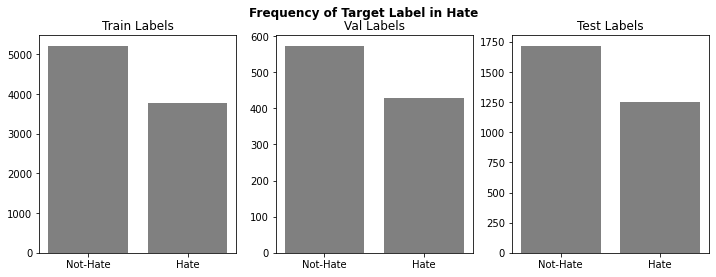

In [17]:
visualise_label_distribution(dataset='hate')

The binary label *Hate* (42%) or *Non-Hate* (58%) seems reasonably balanced. Here, balancing of the labels before building the model is possible, but not mandatory. It furthermore becomes obvious that the label ratio is consistent across all splits (training, validation and testing set).

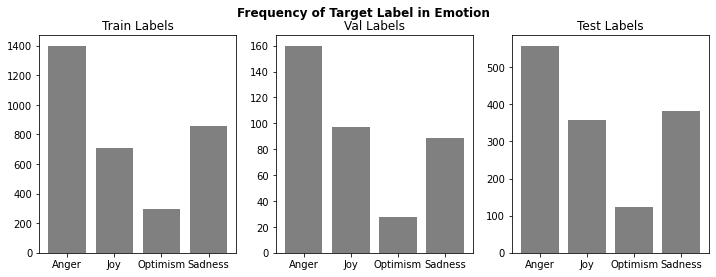

In [18]:
visualise_label_distribution(dataset='emotion')

However, in the multi-class classifcation task we observe a high imbalance. With only 9% of the total amount of data in each split, the label *optimism* is underrepresent, while the label *anger* (43%) is overrepresented. This imbalance needs to be addressed before training our classifiers. 
Again, however, we observe a consistent label ratio across all splits. 

# Processing of Language Data
---
*TASK 1*

Natural language is a highly-complex type of data, that needs to be processed before it can be implented meaningfully into a classification task. For natural language classifiers the main step of processing the raw data - the original tweets - is called **tokenisation**.

On a high level, computers stand no chance in understanding language. After all, each and every tweet we are dealing with is just a unique concatenation of 0's and 1's, that in itself is useless for classifying the tweet in any way. We must therefore transform our data in a way that our computer is able to understand it. This is done during the process of tokenisation in natural language processing. Tokenisation in NLP generally means the concept of breaking down the original data into smaller parts, called tokens. Those tokens could be sentences, one or more words, or even smaller chunks of text. Either way, they are used to built a vocabulary that ultimately results in a count vector machine, that serves as input to the machine learning model.

## Building Tokeniser
---
In this project we chose to build a word-tokeniser, meaning that the ideal tokeniser recognises words and splits accordingly. However, due to the fact that we are working with tweet data, there are some special requirements in order to get optimal performance in our models. 

**Features of Tokeniser**

1. Lowercase ()

2. Links (Links are a core part of a tweet containing it - if not the core. To not lose information, we must include the links in our classification. However, for the classfication the actual link address is of minor importance. For this reason, we would like to recognise any link, then replace it with some dummy string that the model uses to classify any kind of link in a tweet.

3. Emojis (Emojis have developed to a central method of communicating emotions. It is therefore important that our tokeniser recognises single emojis and feeds them into our classifier.)

4. Hashtags ()

4. Contractions (Has not or Hasn't? It means the same, so we would like our model to recognise the two as the same token.)


The following code cells contain how the tokeniser was built in this project. It is fundamentally based on the *Tweet Tokeniser* provided by the NLTK library and then adds additional functionality using both RegEx and another extyernally trained model for tokenising contractions correctly.

In [19]:
# loading pre-trained contraction model
if PREPROCESS_DATA == True:
    cont.load_models() # doesn't work on deepnote, because of memory issues. works locally

cont = Contractions(api_key="glove-twitter-200")

In [20]:
# define url regex pattern and replace pattern globally (compile for speedup)
url_pattern = re.compile(r"(?i)((?:https?://|www\d{0,3}[.]|[a-z0-9.-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|(([^\s()<>]+|(([^\s()<>]+)))))+(?:(([^\s()<>]+|(([^\s()<>]+))))|[^\s`!()[]{};:'\".,<>?«»\“\”‘’]))")
dummy = " <=LINK=> "

# brush up functions
def remove_links(tweet):
    return re.sub(url_pattern, dummy, tweet) # substituting dummy for every link

def remove_newline(tweet):
    return re.sub(r'\\n', ' ', tweet) # deals with issue of newline characters within tweets

def expand(tweet):
    return list(cont.expand_texts([tweet]))[0] # expands contractions

In [21]:
tk = TweetTokenizer()

def tokenise(tweet):
    cleaned_tweet = expand(remove_links(remove_newline(tweet.lower())))
    return tk.tokenize(cleaned_tweet)

## Exporting Tokenised Tweets
---
We have built the final tokeniser that will be used throughout this project. To not stretch out the RAM, we iterate over the raw data tweet by tweet, tokenise it and write it into an external file. The final tokenised tweets will be separated by tabs, such that they can easily be read back in again, while keeping the split between tokens. 

For both datasets, all processed files will be in saved into a subfolder called `hate` or `emotion` within the folder `processed` in `data`. While exporting, we maintain the naming convention of the raw data. This enables us to use the same function to read in the processed data again. 

*Note that directories are created automatically and thus do not need to be created by hand.*

In [22]:
if PREPROCESS_DATA == True:
    for dataset in DATASETS:
        # create preprocessed folder
        try: os.makedirs(f'../data/processed/{dataset}')
        except: None

        # preprocess and tokenize tweets
        for key in ['train_text', 'val_text', 'test_text']:
            with open(f'../data/processed/{dataset}/{key}.txt', 'w', encoding = 'UTF-8') as outfile:
                for tweet in DATA['raw'][dataset][key]:
                    outfile.write('\t'.join(tokenise(tweet)) + '\n') # writing tokenised tweet with tab delimiter

        # copy labels and mapping without preprocessing
        for key in ['train_labels', 'val_labels', 'test_labels', 'mapping']:
            shutil.copyfile(f'../data/raw/{dataset}/{key}.txt', f'../data/processed/{dataset}/{key}.txt')

In [23]:
# loading in processed data
for dataset in DATASETS:
    for key in os.listdir(f'../data/processed/{dataset}'):
        with open(f'../data/processed/{dataset}/{key}', 'r', encoding='UTF-8') as infile:
            DATA['processed'][dataset][key[:-4]] = [line.strip().split('\t') for line in infile.readlines()]

    # convert target labels to integers
    for key in ['train_labels', 'val_labels', 'test_labels']:
        DATA['processed'][dataset][key] = [int(x) for x in [DATA['processed'][dataset][key][i][0] for i in range(len(DATA['processed'][dataset][key]))]]

    # convert mapping to dictionary
    DATA['processed'][dataset]['mapping'] = {int(string[0]): string[1] for string in DATA['processed'][dataset]['mapping']}

## Testing Tokeniser
---
The tokeniser is built and has been applied onto the entire corpus. Let's evaluate its performance using the same first ten tweets as we peeked into in the first section.

In [24]:
for i in range(10):
    print(f"Original Tweet: {DATA['raw']['hate']['train_text'][i]}\nTokenised Tweet: {'-'.join(DATA['processed']['hate']['train_text'][i])}\n")

Original Tweet: @user nice new signage. Are you not concerned by Beatlemania -style hysterical crowds crongregating on you…
Tokenised Tweet: @user-nice-new-signage-.-are-you-not-concerned-by-beatlemania---style-hysterical-crowds-crongregating-on-you-…

Original Tweet: A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎
Tokenised Tweet: a-woman-who-you-fucked-multiple-times-saying-yo-dick-small-is-a-compliment-you-know-you-hit-that-spot-😎

Original Tweet: @user @user real talk do you have eyes or were they gouged out by a rapefugee?
Tokenised Tweet: @user-@user-real-talk-do-you-have-eyes-or-were-they-gouged-out-by-a-rapefugee-?

Original Tweet: your girlfriend lookin at me like a groupie in this bitch!
Tokenised Tweet: your-girlfriend-lookin-at-me-like-a-groupie-in-this-bitch-!

Original Tweet: Hysterical woman like @user
Tokenised Tweet: hysterical-woman-like-@user

Original Tweet: Me flirting- So tell me about your father...
Tokenised 

In [25]:
for i in range(10):
    print(f"Original Tweet: {DATA['raw']['emotion']['train_text'][i]}\nTokenised Tweet: {'-'.join(DATA['processed']['emotion']['train_text'][i])}\n")

Original Tweet: “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
Tokenised Tweet: “-worry-is-a-down-payment-on-a-problem-you-may-never-have-'-.-joyce-meyer-.-#motivation-#leadership-#worry

Original Tweet: My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
Tokenised Tweet: my-roommate-:-it-is-okay-that-we-cannot-spell-because-we-have-autocorrect-.-#terrible-#firstworldprobs

Original Tweet: No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
Tokenised Tweet: no-but-that-is-so-cute-.-atsu-was-probably-shy-about-photos-before-but-cherry-helped-her-out-uwu

Original Tweet: Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
Tokenised Tweet: rooneys-fucking-untouchable-is-not-he-?-been-fucking-dreadful-again-,-depay-has-looked-decent-(-ish-)-tonight

Original Tweet: it's pretty depressing when u

In both small samples from the two datasets the tokeniser seems to perform well. As expected, we split the tweets by words. Furthermore, the tokeniser is able to keep hashtags, expand contractions, deal correctly with emojis and replace links with the dummy string.
We can now continue our work based on the tokenised data.

# Descriptive Statistics
---
*TASK 2* 

An essential part of any NLP classfication task is to describe the corpus, so the entire tokenised data. In this section, we will step-by-step compute the most important statistics and visualise some of them for both datasets.

## Corpus
---
Generally in linguistics, a corpus is a large and structured set of texts. The corpus is often used as the basis for a lot of descriptive analysis of the language data at hand. We therefore create a corpus for both training sets of our datasets using a flattened list, that is a linear conctentation of all tokens in the training sets of both datasets.

In [26]:
# build entire corpus from training set in both datasets
for dataset in DATASETS:
    CORPUS[dataset] = [token for tweet in DATA['processed'][dataset]['train_text'] for token in tweet]

In [27]:
for dataset in DATASETS:
    print(f'Corpus Size ({dataset.title()}): {len(CORPUS[dataset])}')

Corpus Size (Hate): 216076
Corpus Size (Emotion): 60506


As we can see, the corpus for the `hate` classification is significantly larger with 216.076 total number of tokens than the `emotion` corpus with 60.506 tokens.

## Vocabulary 
---
In NLP, the set of unique words used in the text corpus is referred to as the vocabulary. The vocabulary is the basis for training machine learning models based on the bag-of-words approach, which treats every unique token as a feature in the classification.

In order to built the vocabulary, we use the `Counter` class from the `collections` standard library in python onto the corpus, in order to compute a dictionary containing all unique tokens (types) together with their corresponding frequency. We combine all data, together with some additional information like the `rank`, where 1 is the the most frequent token, the `normalised/ relative frequency` (frequency divided by total number of tokens) and the `cumulative frequency`. The final data frame will be sorted in descending order, from most to least frequent tokens.

In [28]:
# build entire vocabulary from training tweets in both datasets
for dataset in DATASETS:
    corpus = CORPUS[dataset]

    # initialise frequency counter
    VOCABULARY[dataset] = pd.DataFrame.from_dict(Counter(corpus), orient='index').reset_index().rename(columns={'index': 'token', 0: 'frequency'}).sort_values(by='frequency', ascending=False).reset_index().drop(columns=['index'])

    VOCABULARY[dataset]['rank'] = VOCABULARY[dataset].index + 1 # add one to index to build rank
    VOCABULARY[dataset]['normalised_frequency'] = VOCABULARY[dataset]['frequency'] / VOCABULARY[dataset]['frequency'].sum() # relative frequency
    VOCABULARY[dataset]['cumulative_frequency'] = VOCABULARY[dataset]['normalised_frequency'].cumsum()

Let's have a look at the vocabulary dataframes constructed for both dataframes.

In [29]:
VOCABULARY['hate']

,token,frequency,rank,normalised_frequency,cumulative_frequency
0,.,6277,1,0.029050,0.029050
1,@user,6014,2,0.027833,0.056883
2,the,5492,3,0.025417,0.082300
3,to,4931,4,0.022821,0.105120
4,",",4356,5,0.020160,0.125280
...,...,...,...,...,...
18595,weren,1,18596,0.000005,0.999981
18596,miaow-miaow-miaow,1,18597,0.000005,0.999986
18597,aaaaw,1,18598,0.000005,0.999991
18598,food-hole,1,18599,0.000005,0.999995


In [30]:
VOCABULARY['emotion']

,token,frequency,rank,normalised_frequency,cumulative_frequency
0,@user,2019,1,0.033369,0.033369
1,.,1977,2,0.032674,0.066043
2,the,1519,3,0.025105,0.091148
3,to,1258,4,0.020791,0.111939
4,i,1177,5,0.019453,0.131392
...,...,...,...,...,...
9259,article's,1,9260,0.000017,0.999934
9260,fanbase,1,9261,0.000017,0.999950
9261,cules,1,9262,0.000017,0.999967
9262,madridistas,1,9263,0.000017,0.999983


## Type/ Token Ratio
---
The type/ token ratio of is the quotient of number of types (vocabulary size) to number of tokens (text/corpus size). We compute it in the following way. 

In [31]:
for dataset in DATASETS:
    print(f'TTR ({dataset.title()}): {round(len(VOCABULARY[dataset]) / len(CORPUS[dataset]),2)}')

TTR (Hate): 0.09
TTR (Emotion): 0.15


A high TTR generally indicates a high degree of lexical variation in the corpus. However, in this context the higher TTR in the emotion dataset might also result from the fact that it is a lot smaller in size than the hate dataset and thus the TTR score is less biased by few very frequently occurring tokens that decrease the TTR score.

## Zipf's Law
---
Zipf's Law says that the frequency of a word is inversely proportional to its rank in the frequency table. Thus, very few words occur very frequently, while the majority of words have very low frequencies. Tyical frequent words are function words, such as prepositions, pronouns, conjunctions and similar words.

Let's visualise Zipf's Law for both of our datasets.

In [32]:
def visualise_zipf(dataset, log = False):
    if log:
        x = np.log(VOCABULARY[dataset]['rank'])
        y = np.log(VOCABULARY[dataset]['frequency'])
    else: 
        x = VOCABULARY[dataset]['rank']
        y = VOCABULARY[dataset]['frequency']

    fig, ax = plt.subplots(ncols=2, figsize=(15,6))
    ax[0].plot(x, y);
    ax[0].set_xlabel('Rank'); ax[0].set_ylabel('Frequency'); ax[0].set_title(f'Frequency of Tokens in {dataset.title()}'); 
    ax[1].plot(VOCABULARY[dataset]['rank'], VOCABULARY[dataset]['cumulative_frequency']);
    ax[1].set_xlabel('Rank'); ax[1].set_ylabel('Cumulative Frequency'); ax[1].set_title(f'Cumulative Frequency of Tokens in {dataset.title()}'); 

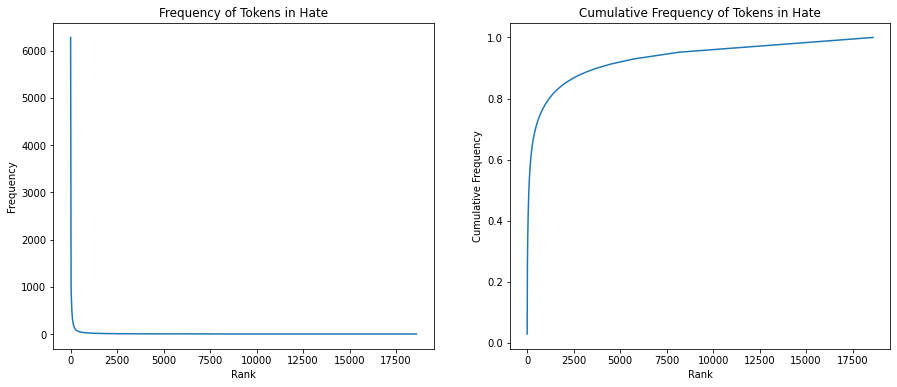

In [33]:
visualise_zipf(dataset='hate', log=False)

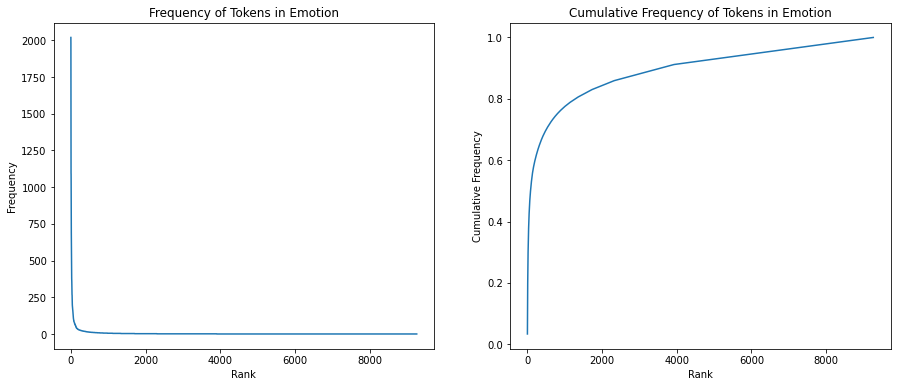

In [34]:
visualise_zipf(dataset = 'emotion', log = False)

# Digression: N-Gram Model
---
N-Gram Language models are an important tool in NLP, i.e. used in the context of auto-completion or tools like spell checkers. The idea of the model is rather simple: Given a sequence of words, predict the next word that appears with highest probability. In that sense, N-Gram models are a way of finding the maximum likelihood word after a sequence of previous words. But, how do we find this maximum likelihood word? From the point of probability theory, the probability of a word occuring is the conditional probability of seeing some word, given that we already know that that a sequence of previous words has occurred. However, calculating those probabilites for bigger coropora is computationally infeasible. 

However, one can simplify the computation. The *k*th order *Markov assumption* states that each element of a sequence of tokens only depends on the *k* immediately preceding elements, such that manual 

$$
p(w_i|w_{1}, ...,w_{i-1}) \approx (w_i|w_{i-k}, ..., w_{i-1})
$$



*Note: For exploring n-gram models we are using the training set of the `hate` dataset.*

## Manual Model Prediction
---
Before using external libraries to implement n-gram models, we wanted to give it a shot and code it out for ourselves in the simplest of all cases, the bigram. In this simple model we iterate over each tokenised tweet in the data pairwise, and while doing so incrementing the counter of seeing word 2, given that we have seen word 1 in a nested dictionary. We can then easily convert those counts into conditional probability and from that choose the word that is maximally likely give some word. A `generate` function is then the natrual extension that consecutively chooses the next most likely word for a sequence of *n* words.

In [35]:
from nltk import bigrams
from collections import Counter, defaultdict

class OurBigram:
    def __init__(self):
        # initialise empty skeleton structure of model as nested dictionary (initialise all counts to 0)
        self.model = defaultdict(lambda: defaultdict(lambda: 0))
    
    def fit(self, data):
        # count frequency of co-occurances
        for sentence in data:
            for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True):
                self.model[w1][w2] += 1
            
        # transform counts to conditional probabilities
        for w1 in self.model:
            total_count = float(sum(self.model[w1].values()))
            for w2 in self.model[w1]:
                self.model[w1][w2] /= total_count

    def find_mle(self, word):
        # for a given word return the word that occurs next with maximum likelihood
        return max(self.model[word], key=self.model[word].get)
            
    def generate(self, word, n):
        # generate a sequence of n words given an initial word from the bigram model
        while n >= 0:
            print(word, end=' ') 
            mle = self.find_mle(word)
            word = mle
            n-=1


bigram = OurBigram()
bigram.fit(DATA['processed']['hate']['train_text'])
bigram.generate('hey', 4)

hey that is a woman 

## NLTK Language Model
---
In this section, we are exploring externally implemented language models from the NLTK library that we assume ot perform overall better, i.e. in the way it deals with unseen tokens. The following lines of code show, how the model is being trained on hte training set of the `hate` data. We finally generate a sample tweet of length ten.

In [36]:
# imports for n-gram language model
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

In [37]:
# number of grams
n=5

# split 
train, vocab = padded_everygram_pipeline(n, DATA['processed']["hate"]["train_text"])

# initialise and fit data
lm = MLE(n)
lm.fit(train, vocab)

In [38]:
'hitler ' + ' '.join(lm.generate(10, text_seed=['hitler'], random_seed=10))

'hitler may come back from the grave just to choke merkel'

We can see that the model is capable of occational, syntactically correct and plausible, hate speech.

# Digression: Manual Annotations and Inter-Annotator Agreement (IAA)
---
*TASK 3*

Classification tasks in ML are concerned with predicting a class membership of some object based on computed features. Just as with any other type of objects of data we are dealing with, there are different ways of predicting these labels. 

1. **Explicit Rules**: Defining explicit rules in what instances of features, what label to predict

2. **Unsupervised Learning**: Letting the machine find clusters within the data by itself

3. **Supervised Learning**: Manually enriching the data with additional information through annotation.

Defining explicit decision rules is most of the times infeasible for more complex classfication problems. Likewise, unsupervised learning models in NLP often do not give the wanted results. For this reason, the predominant method for knowledge encoding when dealing with natural language is the supervised learning that involves the process of manual annotation. 

Manually annotating data means to define some kind of *gold standard*, which the label our model ideally predicts. However, this in itself can be a challenge, since language can be ambigious, and interpretation is often subject of personal opinion. 

In this section we therefore manually annotate a small percentage (100 tweets) of the training corpus in the `hate` dataset and compute metrics to what degree we agreed on class membership. We followed the [Annotation Guidelines](https://github.com/msang/hateval/blob/master/annotation_guidelines.md) as employed by the source of the data ([Final Paper](https://www.aclweb.org/anthology/S19-2007.pdf))


## Generate IAA Sample
---
We first generate the sample of tweets and corresponding gold standard labels as reported by the source of the data. For ease, we chose the last 100 tweets from the training corpus of the `hate` dataset. The tweets were exported into a separate file in the directory `data/annotations`.

In [39]:
if GENERATE_IAA_SAMPLE == True:
    with open('../data/annotations/annotation_sample.txt', 'w') as outfile:
        for tweet in DATA['raw']['hate']['train_text'][-100:]: # last 100 tweets in hate training set
            outfile.writelines(tweet + '\n')
    with open('../data/annotations/ground_truth_annotation_sample.txt', 'w') as outfile:
        for label in DATA['raw']['hate']['train_labels'][-100:]:
            outfile.writelines(str(label) + '\n')

Without looking at the gold standard labels from the source of the data, each member of the group individually annotated the 100 tweets and uploaded the file into the folder `data/annotations/manual_annotations`. The following section evaluates the results of this annotation.

## Evaluation
---
There exist different metrics for evaluating annotations of multiple annotators, which we will compute within this section. For easy dealing, we read in the manual annotations and load them into a single dataframe, containing both the original tweet, the gold standard label and the four annotated labels by each group member.

In [40]:
# compare manual annotations through building dataframe
annotation_evaluation = pd.DataFrame({'tweets': DATA['raw']['hate']['train_text'][-100:], 'ground_truth': DATA['raw']['hate']['train_labels'][-100:]})

for filename in os.listdir('../data/annotations/manual_annotations'): # opening manually annotated files
    with open(f'../data/annotations/manual_annotations/{filename}', 'r') as infile:
        annotation_evaluation[filename[:-4]] = [int(line.strip()) for line in infile.readlines()]

In [41]:
annotation_evaluation

,tweets,ground_truth,nicola_annotations,hugo_annotations,mika_annotations,aidan_annotations
0,Cry baby Hollywood Dems Anti-Trump celebs too ...,0,0,0,0,0
1,@user Do I have to fight another bitch ass loo...,1,1,0,1,1
2,#SouthCarolina has spent millions of dollars t...,0,0,0,0,0
3,Me trying to flirt- I wanna eat your hot pocket,0,0,0,0,0
4,"People say, ""Why didn't this or that immigrant...",0,0,0,0,0
...,...,...,...,...,...,...
95,Oooohhhh bitch didn't even listen to the dead ...,0,1,0,0,1
96,@user Good Luck @user More Americans #WalkAway...,0,1,0,0,0
97,Bitch you can't keep up so stop trying,1,1,0,1,0
98,@user @user @user @user @user @user Japan is a...,0,0,0,0,0


### Classification Report 
---
One way of evaluating the annotation is to treat each annotator as a machine learning model that predicted some label. Then comparing the predicted labels with the set gold-standard allows us to compute common evaluation metrics, such as accuarcy, recall and sensitivity and f-scores, in order to evaluate the quality of the annotations in relation to the assumed gold standard.

#### Nicola

In [42]:
print('#'*23 + ' ' + 'Nicola' + ' ' + '#'*23 + '\n')    
print(pd.DataFrame(confusion_matrix(annotation_evaluation['ground_truth'], annotation_evaluation['nicola_annotations']), columns=['Predicted Non-Hate', 'Predicted Hate'], index=['Non-Hate', 'Hate']))
print('\n')
print(classification_report(annotation_evaluation['ground_truth'], annotation_evaluation['nicola_annotations'], target_names=["Non-Hate","Hate"]))

####################### Nicola #######################

          Predicted Non-Hate  Predicted Hate
Non-Hate                  51               6
Hate                       7              36


              precision    recall  f1-score   support

    Non-Hate       0.88      0.89      0.89        57
        Hate       0.86      0.84      0.85        43

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



#### Hugo

In [43]:
print('#'*23 + ' ' + 'Hugo' + ' ' + '#'*23 + '\n')    
print(pd.DataFrame(confusion_matrix(annotation_evaluation['ground_truth'], annotation_evaluation['hugo_annotations']), columns=['Predicted Non-Hate', 'Predicted Hate'], index=['Non-Hate', 'Hate']))
print('\n')
print(classification_report(annotation_evaluation['ground_truth'], annotation_evaluation['hugo_annotations'], target_names=["Non-Hate","Hate"]))

####################### Hugo #######################

          Predicted Non-Hate  Predicted Hate
Non-Hate                  57               0
Hate                      28              15


              precision    recall  f1-score   support

    Non-Hate       0.67      1.00      0.80        57
        Hate       1.00      0.35      0.52        43

    accuracy                           0.72       100
   macro avg       0.84      0.67      0.66       100
weighted avg       0.81      0.72      0.68       100



#### Mika

In [44]:
print('#'*23 + ' ' + 'Mika' + ' ' + '#'*23 + '\n')    
print(pd.DataFrame(confusion_matrix(annotation_evaluation['ground_truth'], annotation_evaluation['mika_annotations']), columns=['Predicted Non-Hate', 'Predicted Hate'], index=['Non-Hate', 'Hate']))
print('\n')
print(classification_report(annotation_evaluation['ground_truth'], annotation_evaluation['mika_annotations'], target_names=["Non-Hate","Hate"]))

####################### Mika #######################

          Predicted Non-Hate  Predicted Hate
Non-Hate                  53               4
Hate                      10              33


              precision    recall  f1-score   support

    Non-Hate       0.84      0.93      0.88        57
        Hate       0.89      0.77      0.82        43

    accuracy                           0.86       100
   macro avg       0.87      0.85      0.85       100
weighted avg       0.86      0.86      0.86       100



#### Aidan

In [45]:
print('#'*23 + ' ' + 'Aidan' + ' ' + '#'*23 + '\n')    
print(pd.DataFrame(confusion_matrix(annotation_evaluation['ground_truth'], annotation_evaluation['aidan_annotations']), columns=['Predicted Non-Hate', 'Predicted Hate'], index=['Non-Hate', 'Hate']))
print('\n')
print(classification_report(annotation_evaluation['ground_truth'], annotation_evaluation['aidan_annotations'], target_names=["Non-Hate","Hate"]))

####################### Aidan #######################

          Predicted Non-Hate  Predicted Hate
Non-Hate                  53               4
Hate                      13              30


              precision    recall  f1-score   support

    Non-Hate       0.80      0.93      0.86        57
        Hate       0.88      0.70      0.78        43

    accuracy                           0.83       100
   macro avg       0.84      0.81      0.82       100
weighted avg       0.84      0.83      0.83       100



In summary, the confusion matrices and classification reports show that the even in a relatively small sample of only 100 tweets and only four different annotators, hate-speech seems to be perceived differently. Within the group, Nicola was most sensitive towards hate speech, meaning that out of all she labelled the most tweets as being hate speech. This resulted in a high recall score on the hate data and an overall balanced prediction. Hugo, in turn only tagged 15 tweets as being hate speech. His insensitivy towards labelling hate speech resulted in a high perfect recall score on non-hate and perfect precision on hate, i.e. whenever he labelled something as hatespeech, there is absolutely no doubt that it is actually hate speech. However, he also falsely predicted a lot of hate-tweets as being non-hate, resulting in a poor recall score on hate tweets. 

The reports show that annotation of language data with regards to the general *state-of-mind* of the author is subject to personal perception. Thus, we have to find ways of agreeing on some gold-standard. The following chapter explores how we can numerically summarise annotations of multiple annotators to agree on target labels.

### Cohen's Kappa
---
Cohen's Kappa ($\kappa$) is an evaluation metric that is used to measure inter-rater reliability for labelling (categorical) items. In NLP it is i.e. used to compare the annotations of a single annotator with the original annotations. In general, Cohen's Kappa is preferred over simple percentage of agreement, since it corrects the score by the agreement that would be expected by pure chance. 
Cohen's Kappa values range from  from in the interval $\kappa \in [-1,1]$, with larger values indicating higher agreement between two classifications. 

The following code cell computes the Cohen's Kappa score for each annotator using the function `cohen_kappa_score` from `sci-kit learn`.

In [46]:
# compute cohen's kappa score for each annotator
for person in list(annotation_evaluation)[-4:]:
    print(f'{person[:-12].title()}:\t {round(cohen_kappa_score(annotation_evaluation["ground_truth"], annotation_evaluation[person]),2)}')

Nicola:	 0.73
Hugo:	 0.38
Mika:	 0.71
Aidan:	 0.64


The Cohen Kappa scores of the group's annotations suggest a *substantial agreement* with the original labelling, as three out of four of the scores are above 0.61. Hugo's score is less but is still considered *fair*.

One can summarise, that from the Cohen Kappa scores there is no substantial evidence against the original labelling being invalid.

### Fleiss Kappa
---
Fleiss' Kappa is a statistical measure for assessing the reliability of agreement between a fixed number of annotators when labels to a number of classifying items. In contrast to Cohen's Kappa it is metric between multiple annotators and is not only 

The measure calculates the degree of agreement in classification over that which would be expected by chance.

In [47]:
# fleiss kappa with ground_truth
annotation_list = []
for row_index in range(len(annotation_evaluation)):
    zero = len([elm for elm in annotation_evaluation.iloc[row_index, 1:] if elm == 0])
    annotation_list.append([zero, 5-zero])

annotation_table = np.array(annotation_list)

print("Fleiss's K (Including Ground Truth):", round(fleiss_kappa(annotation_table),2))

# fleiss kappa without ground_truth
annotation_list = []
for row_index in range(len(annotation_evaluation)):
    zero = len([elm for elm in annotation_evaluation.iloc[row_index, 2:] if elm == 0])
    annotation_list.append([zero, 4-zero])

annotation_table = np.array(annotation_list)

print("Fleiss's K (Excluding Ground Truth):", round(fleiss_kappa(annotation_table),2))

Fleiss's K (Including Ground Truth): 0.54
Fleiss's K (Excluding Ground Truth): 0.49


In both cases, the Fleiss Kappa score can be interpreted as a *moderate agreement*.

The fact that the kappa score is higher with the ground truth labels being included tells us that the the 3/4 people who are more in agreement with eachother are more in agreement with the original labelling than Hugo's. 

# Classification
---
*TASK 4*

The final task of the project is to build the classifier both for the binary and the multiclass classification based on the bag-of-words model. It is a classical approach of extracting features from rich langauge in order to make automated predictions. The following general process was followed and implemented in the `build_model` function:

1. **Combining Training and Validation Splits into Development Set**

2. **Construct Pipeline**

3. **GridSearch for Hyperparameter Tuning**

4. **Model Evaluation**

The first step of the classifcation task combines the training and validation split, into one development set. This is possible, since at a later point in the classification the `GridSearchCV` method is going to run automatic cross-validation in order to identify the best parameters. 

We then build a pipeline that takes the development set as input and consecutively works on the data: Firstly, the raw tokenised data is transformed into a sparse matrix using the `CountVectorizer` class. This creates a sparse matrix of small numeric values in the number of columns being the vocabulary size of the entire development corpus and the number of rows being the number of total tweets in the development set. Once the language data is transformed into numerical attributes, we can continue to work on the data, in order to build a best-performing model. Firstly, we upsample minority classes using the `SMOTE` oversampler, which synthetically creates new datapoints of the minority class by finding patterns in the existing datapoints of that claas. Through `TFidf Transformation` we compute the relevance of a token within some corpus and is a typically used tool in NLP in order to increase the performance of classifiers. Lastly, the pipeline trains a `SGD Classifier`.

We use `GridSearchCV` to find the parameters that optimise the overall performance of the model we are building. We therefore define several hyperparameters into a dictionary of parameters, that should be evaluated. The grid automatically performs cross validation on the development set in *n=5* splits and returns the model that optimises for `f1_macro` score. In that way, the resulting model will be optimmised for predicting individual classes equally well.

In [106]:
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

kf = KFold(n_splits=5, shuffle=False)

def build_model(dataset):
    # combining train and validation, because grid search cross validates to find best params
    X_dev = DATA['processed'][dataset]['train_text'] + DATA['processed'][dataset]['val_text']
    y_dev = DATA['processed'][dataset]['train_labels'] + DATA['processed'][dataset]['val_labels']

    # building pipeline to build classifier
    # a) vectorise tokenised tweets into sparse matrix 
    # b) oversampling
    # c) term frequency inverse document frequency for better performance
    # d) train SGD classifier 
    classifier = Pipeline([('vect', CountVectorizer(preprocessor=lambda x:x, tokenizer=lambda x:x, stop_words=stopwords.words('english'))),
                           ('ovs', SMOTE()),
                           ('tfidf', TfidfTransformer()),
                           ('clf', SGDClassifier())])

    # hyperparameters to tune
    parameters = {
        'vect__max_df': (0.7, 0.9),                # cutoff tokens that appear in more than (100*p)% of tweets
        'vect__min_df': (0, 0.05),                 # cutoff tokens that appear in less than (100*p)% of tweets
        'vect__stop_words': [None, 'english'],     # inlude/ exclude stopwords
        'tfidf__use_idf': (True, False),           # use/ not use tfidf
        #'tfidf__norm': ('l1', 'l2'),
        'clf__loss': ['hinge', 'log'],             # loss function of sgd classifier
        'clf__alpha': (0.00001, 1e-3),
        #'clf__penalty': ('l2', 'elasticnet'),
    }

    grid = GridSearchCV(classifier, param_grid = parameters, cv=kf, n_jobs=-1, scoring='f1_macro')
    grid = grid.fit(X_dev, y_dev) # fit

    print('Found Optimal Parameters!')
    print(f'Parameters: {grid.best_params_}')
    print(f'Best Macro F1-Score: {grid.best_score_}')

    return grid

## Binary Classification
---
We now use the above-defined function to build our model for the `hate` dataset. We therefore simply run the function with the correct function arguments. The time of computation depends on the number of hyperparameters to tune. 

*In the current configuration, model training takes:  $\sim$400s*

In [107]:
hate_model = build_model(dataset = 'hate')

Found Optimal Parameters!
Parameters: {'clf__alpha': 1e-05, 'clf__loss': 'log', 'tfidf__use_idf': True, 'vect__max_df': 0.9, 'vect__min_df': 0, 'vect__stop_words': None}
Best Macro F1-Score: 0.7364209674541285


The `GridSearchCV` returned the best-performing model with the given hyperparameters. We now evaluate on the so-far untouched test data to evaluate the final performance of the model.

In [108]:
# evaluate
X_test, y_test = DATA['processed']['hate']['test_text'], DATA['processed']['hate']['test_labels']

predictions = hate_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.19      0.30      1718
           1       0.45      0.91      0.60      1252

    accuracy                           0.49      2970
   macro avg       0.60      0.55      0.45      2970
weighted avg       0.62      0.49      0.43      2970



## Multiclass Classification
---
We train the model for the emotion recognition in a similar fashion by using the above-defined function. We therefore simply run the function with the correct function arguments. The time of computation depends on the number of hyperparameters to tune. 

*In the current configuration, model training takes:  $\sim$200s*

In [109]:
emotion_model = build_model(dataset = 'emotion')

Found Optimal Parameters!
Parameters: {'clf__alpha': 1e-05, 'clf__loss': 'log', 'tfidf__use_idf': True, 'vect__max_df': 0.7, 'vect__min_df': 0, 'vect__stop_words': 'english'}
Best Macro F1-Score: 0.6143089557291297


The `GridSearchCV` returned the best-performing model with the given hyperparameters. We now evaluate on the so-far untouched test data to evaluate the final performance of the model.

In [110]:
# evaluate
X_test, y_test = DATA['processed']['emotion']['test_text'], DATA['processed']['emotion']['test_labels']

predictions = emotion_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75       558
           1       0.71      0.67      0.69       358
           2       0.30      0.34      0.32       123
           3       0.65      0.69      0.67       382

    accuracy                           0.67      1421
   macro avg       0.60      0.61      0.61      1421
weighted avg       0.68      0.67      0.67      1421



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ea65742-831a-48cd-9d56-a22e1ed66c7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>